In [1]:
# import numpy as np
# import math
# from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit.circuit.library import UnitaryGate
# from qiskit.visualization import circuit_drawer
# from qiskit_aer import AerSimulator
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# aer_sim = AerSimulator()
# pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
# sampler = Sampler(aer_sim)

import numpy as np
import qiskit
from tqdm import tqdm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import UnitaryGate, SwapGate, HGate, CXGate
from qiskit.visualization import circuit_drawer

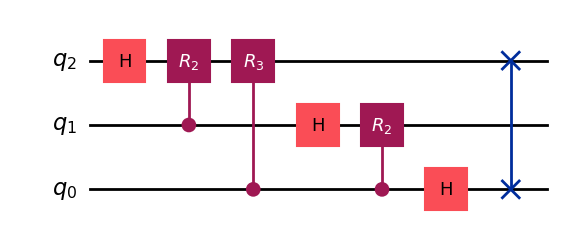

In [2]:
# controlled R gate
def R(k):
    mat = np.array([
        [1, 0],
        [0, np.exp(2j*np.pi/(2**k))]])
    return UnitaryGate( mat, label = f"$R_{k}$")

#Quantum Fourier Transform
def qft(qubits):
    qft = QuantumCircuit(qubits, name = "qft")
    for i in range(qubits-1, -1, -1):
        qft.h(i)
        for j in range(i-1, -1, -1):
            if i-j+1 == 3:
                qft.append(R(3).control(1), [j, i])
            else:
                qft.append(R(i-j+1).control(1), [j, i])
    for i in range(qubits//2):
        qft.swap(i, qubits-i-1)
    return qft

qft_circuit=qft(3)
qft_gate_dagger=qft_circuit.inverse().to_gate()
qft_gate = qft_circuit.to_gate()
qft_circuit.draw('mpl', reverse_bits=True)


In [3]:
init_vector = [1,1j,5/2,4 + 1j,5,7,0,0]
vector = init_vector/np.linalg.norm(init_vector)
state = Statevector(vector)
state = Statevector.from_label('000').evolve(qft_gate)
state.to_dict()


{np.str_('000'): np.complex128(0.35355339059327384-8.088111593903887e-16j),
 np.str_('001'): np.complex128(0.3535533905932736-1.322939188262248e-15j),
 np.str_('010'): np.complex128(0.35355339059327384-1.5545859385897932e-15j),
 np.str_('011'): np.complex128(0.3535533905932734-1.5075439937129229e-15j),
 np.str_('100'): np.complex128(0.35355339059327395-1.389318282766896e-15j),
 np.str_('101'): np.complex128(0.3535533905932735-1.62098417176983e-15j),
 np.str_('110'): np.complex128(0.35355339059327395-1.5855989787777566e-15j),
 np.str_('111'): np.complex128(0.3535533905932733-1.7553043969892967e-15j)}

In [4]:
def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v - sum(np.conj(b) @ v * b for b in basis)
        if np.linalg.norm(w) > 1e-10:  # Avoid division by zero
            basis.append(w / np.linalg.norm(w))
    return np.array(basis)

def vec_to_comp_basis(vec,j):
    vec = vec/np.linalg.norm(vec)
    standard_basis = np.eye(8)
    standard_basis[0],standard_basis[j] = standard_basis.copy()[j],standard_basis.copy()[0]

    vectors = [vec] + [[np.random.rand() + 1 for _ in range(8)] for _ in range(7)]
    orthonormal_basis = gram_schmidt(vectors)
    mat = np.zeros((8, 8), dtype=complex)
    for i in range(8):
        mat += orthonormal_basis[i].reshape(8, 1) @ standard_basis[i].reshape(1, 8)
    # return mat
    return UnitaryGate(mat, label=fr"|\\psi⟩⟨{j}|")

def hadamard_test(gate,j,str = 'real',vector = vector):
    qc = QuantumCircuit(4)
    qc.h(0)
    if str == 'real':
        pass
    elif str == 'imag':
        qc.sdg(0)
    c_gate = gate.control(1)
    qc.append(c_gate, [0,1,2,3])
    c_vec_to_comp = vec_to_comp_basis(vector,j).control(1)
    qc.append(c_vec_to_comp, [0,1,2,3])
    qc.h(0)
    return qc

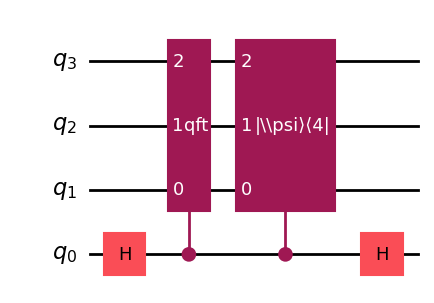

In [5]:
hadamard_test_real_ciruit = hadamard_test(qft_gate,4)
hadamard_test_real_ciruit.draw('mpl', reverse_bits=True)

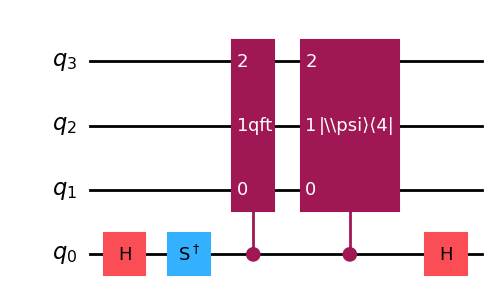

In [6]:
hadamard_test_imag_ciruit = hadamard_test(qft_gate,4,'imag')
hadamard_test_imag_ciruit.draw('mpl', reverse_bits=True)

In [7]:
anicilla_state = Statevector.from_label('0')
data_state = Statevector(vector)
total_state = data_state.tensor(anicilla_state)
total_state_evolved = total_state.evolve(hadamard_test(qft_gate,1,'real'))
dic = total_state_evolved.to_dict()

In [8]:
key = list(dic.keys())
p=0
for k in key:
    if k[-1] == '0':
        p+= dic[k]*np.conj(dic[k])
        
p
        

np.complex128(0.2659098316019734+0j)

In [9]:
def find_probabilities(j,N = 10000,str = 'real'):
    counter = 0
    gate = hadamard_test(qft_gate,j,str)
    for _ in tqdm(range(N)):
        anicilla_state = Statevector.from_label('0')
        data_state = Statevector(vector)
        total_state = data_state.tensor(anicilla_state)
        total_state_evolved = total_state.evolve(gate)
        if total_state_evolved.measure()[0][-1] == '0':
            counter += 1
    return counter/N

In [10]:
find_probabilities(1)

100%|██████████| 10000/10000 [01:49<00:00, 91.14it/s]


0.2656